In [1]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

from matplotlib import pyplot as plt
%matplotlib inline

from werdich_cfr.tfutils.tfutils import use_gpu_devices
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

%load_ext autoreload
%autoreload 2

physical_devices, device_list = use_gpu_devices(gpu_device_string='0,1')

TensorFlow Version: 2.2.0
AVAILABLE GPUs:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
TRAIN DEVICE LIST:
/GPU:0
/GPU:1


### Recover data from TFRecords: look at the postprocessed images ###

In [2]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200617'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date, 'mbf_ammonia')
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'mbf_ammonia_a4c_test_200617_6.tfrecords')
parquet_file = os.path.join(tfr_dir, 'mbf_ammonia_a4c_test_200617_6.parquet')

# feature_dict
feature_dict_file = os.path.join(tfr_dir, 'global_pet_echo_dataset_200617.pkl')
with open(feature_dict_file, 'rb') as fl:
    feature_dict = pickle.load(fl)

# Load df 
df = pd.read_parquet(parquet_file)
df.head(2)

print(feature_dict)

{'array': ['image', 'shape'], 'float': ['rest_global_mbf', 'stress_global_mbf', 'global_cfr_calc'], 'int': ['record'], 'features': ['image', 'shape', 'rest_global_mbf', 'stress_global_mbf', 'global_cfr_calc', 'record']}


In [4]:
df.head(2)

,rest_global_mbf,stress_global_mbf,global_cfr_calc,post-2018,tracer_obi,mrn,study,pet_date,echo_date,petmrn_identifier,days_post_pet,difference(days),pet_measurement,filename,dir,datetime,fileid,institution,model,manufacturer,index,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,a2c_lvocc_s,a3c,a3c_laocc,a3c_lvocc_s,a4c,a4c_far,a4c_laocc,a4c_lvocc_s,a4c_rv,a4c_rv_laocc,a5c,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,max_view,sum_views,dset_mode,rate,im_array_shape
8014,1.290,1.548,1.200000,0,ammonia,2482859,4b79c94984c9fb7e_4903a58793bfceb7caac98f47c1a,2012-06-07,2012-08-03,2482859_2012-06-07,57,57.0,1.0,4b79c94984c9fb7e_4903a58793bfceb7caac98f47c1a_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b79/4b79c9498...,2012-08-03 15:19:26,4b79c94984c9fb7e_4903a58793bfceb7caac98f47c1a_...,BWH,iE33,Philips Medical Systems,0.0,33.333,72.0,52.0,0.048411,0.048411,2.255696e-13,1.424873e-14,4.437052e-15,1.224703e-14,2.391956e-17,4.538256e-15,1.0,2.817868e-14,2.556162e-15,4.197278e-16,5.631014e-13,1.933035e-16,2.717399e-16,3.683348e-14,7.861487e-18,7.021189e-15,1.657676e-15,2.368643e-13,6.098317e-17,9.478077e-15,1.266669e-13,9.186251e-16,5.703351e-16,9.348102e-13,6.321924e-17,9.593358e-21,7.074550e-17,a4c,1.0,test,30.0,"[218, 290, 40]"
5322,0.836,1.584,1.894737,0,ammonia,31081581,48b4c65d7ca5ff9f_4903a58358333064cbac0787029f,2015-09-14,2016-04-11,31081581_2015-09-14,210,210.0,1.0,48b4c65d7ca5ff9f_4903a58358333064cbac0787029f_...,/mnt/obi0/phi/echo/npyFiles/BWH/48b4/48b4c65d7...,2016-04-11 13:29:12,48b4c65d7ca5ff9f_4903a58358333064cbac0787029f_...,BWH,iE33,Philips Medical Systems,0.0,33.333,78.0,70.0,0.048410,0.048410,9.702642e-18,9.905619e-15,5.519489e-17,1.303881e-17,1.679653e-19,1.678624e-16,1.0,6.968646e-16,1.187955e-16,3.673704e-16,5.783145e-15,1.731090e-16,1.408526e-17,2.913420e-16,1.420582e-15,1.723092e-16,9.439424e-17,7.265621e-16,1.411510e-18,3.606317e-17,9.551608e-16,1.173066e-17,7.756220e-17,3.175111e-14,1.710593e-20,5.747912e-22,1.784602e-18,a4c,1.0,test,30.0,"[218, 290, 40]"


In [4]:
n_frames = 40
class_boundaries = (1.232, 1.556, 2.05)
output_height = 299
output_width = 299
augment = False
#im_scale_factor=0.5642
im_scale_factor = 1.177
#im_scale_factor = 3
batch_size = 4
model_output = 'rest_global_mbf'

In [4]:
@tf.function
def cfr_label(cfr_value):
    ''' classification label for cfr value '''
    percentile_list = cfr_boundaries
    label = 0
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    for p in range(1, len(percentile_list)):
        if (cfr_value >= percentile_list[p - 1]) & (cfr_value < percentile_list[p]):
            label = p
    return tf.one_hot(label, depth = len(percentile_list)+1)

In [5]:
# Parameters
batch_size=16

# Dataset
dset_provider = DatasetProvider(feature_dict=feature_dict,
                                output_height=output_height,
                                output_width=output_width,
                                im_scale_factor=1.177,
                                augment=False,
                                model_output=None)
dset = dset_provider.make_batch([tfr_file], 
                                batch_size=batch_size,
                                shuffle=False,
                                buffer_n_steps=2,
                                repeat_count=1,
                                drop_remainder=True)


for out in dset.take(1):
    output = out

In [9]:
dset_provider_aug = DatasetProvider(feature_dict=feature_dict,
                                    output_height=output_height,
                                    output_width=output_width,
                                    im_scale_factor=1.177,
                                    augment=False,
                                    model_output=None)
dset_aug = dset_provider_aug.make_batch([tfr_file], 
                                        batch_size=batch_size,
                                        shuffle=False,
                                        buffer_n_steps=2,
                                        repeat_count=1,
                                        drop_remainder=True)

for out in dset_aug.take(1):
    output_aug = out

In [10]:
# Labels
label_batch = output[1]
print(label_batch.keys())
label_name = 'rest_global_mbf'
label_list = label_batch[label_name].numpy()
#pd.DataFrame({'tfr': label_list, 'df': df[label_name].iloc[:batch_size]})

dict_keys(['rest_global_mbf', 'stress_global_mbf', 'global_cfr_calc', 'record'])


Video batch shape: (16, 40, 299, 299, 1)


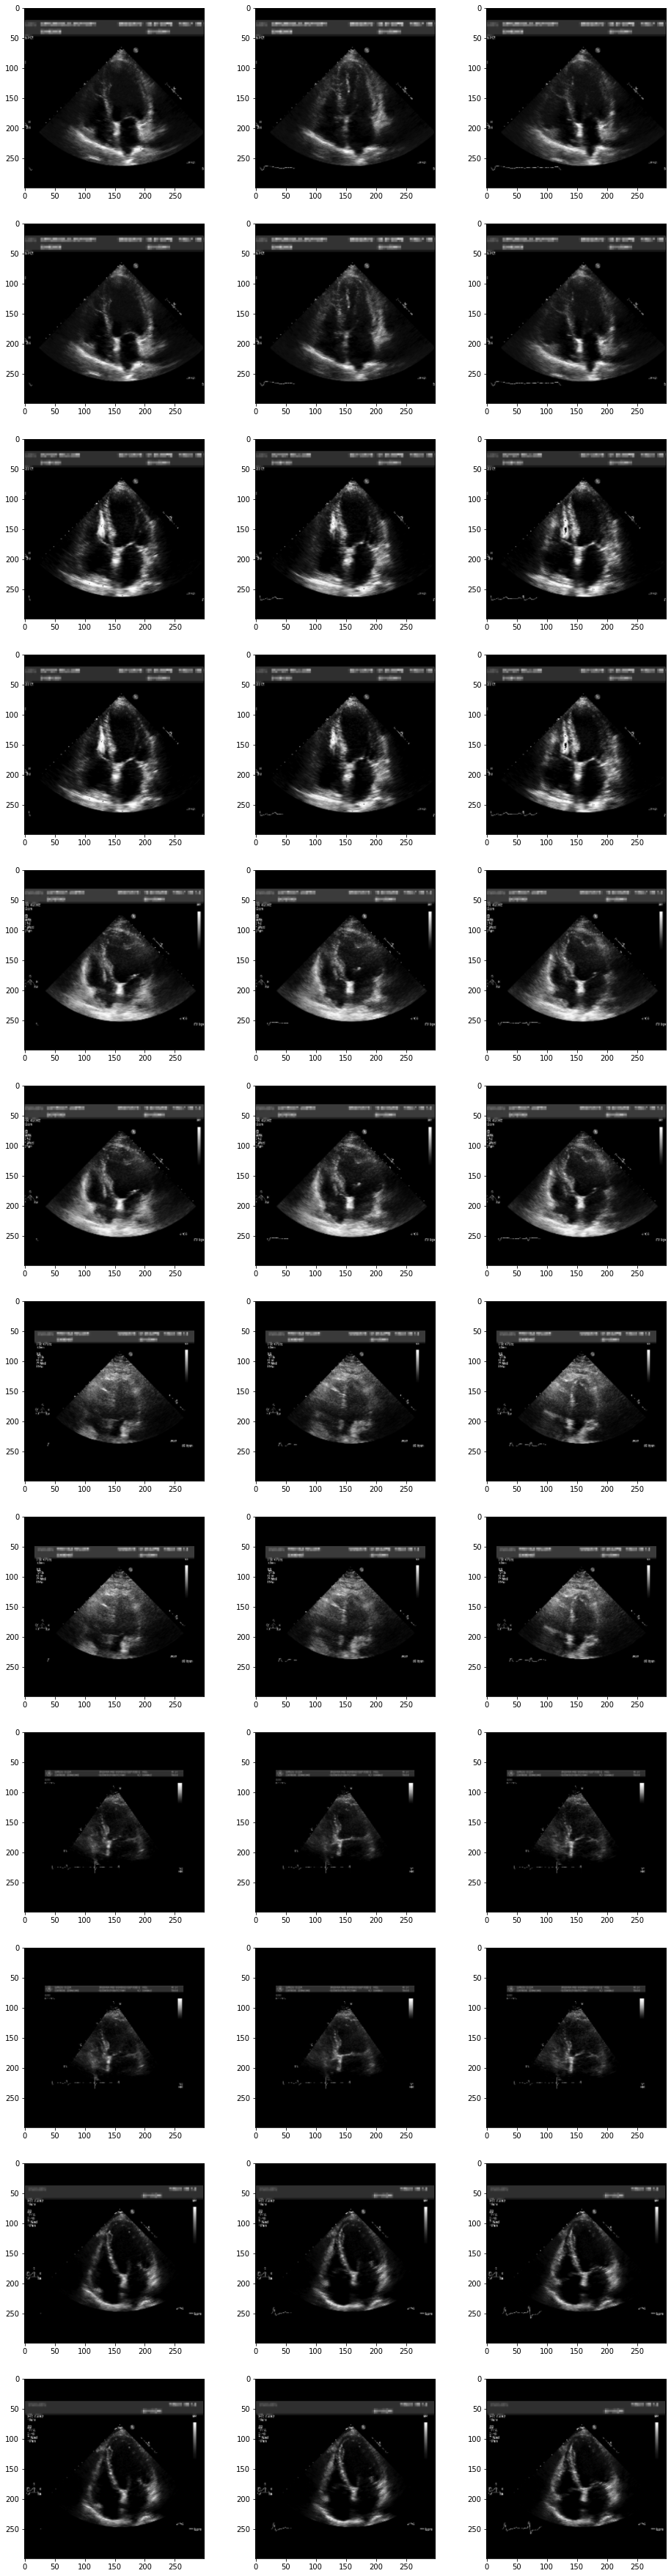

In [11]:
# Output batch is a list of dictionaries [INPUT, OUTPUT]:
image_batch = output[0]['video'].numpy()
image_batch_aug = output_aug[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)

# Show some images from the batch
#sample_idx = np.random.randint(batch_size, size=6)
sample_idx = np.arange(0, 6)
frame_idx = np.random.randint(n_frames, size=3)
fig, ax = plt.subplots(nrows=2*len(sample_idx), ncols=len(frame_idx), figsize = (16,64))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        image_aug = np.squeeze(image_batch_aug[sample, frame, :, :, 0])
        row1 = 2*row
        row2 = row1+1
        ax[row1, col].imshow(image, cmap = 'gray')
        ax[row2, col].imshow(image_aug, cmap = 'gray')